In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit
from sklearn import linear_model
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split
import seaborn as sns
import itertools
import os
import scipy
import pickle

import torch
import torch.nn as nn
import torch.optim as optim

# Prepare Data

In [ ]:
df = pd.read_csv("erdos_renyi_a-g_with_graph_features.csv")

In [ ]:
# List of predictors
predictors = ['p', 'Number of vertices', 'Number of edges', 'Edge density',
       'Mean degree', 'Standard deviation of degrees', 'Skewness of degrees',
       'Minimum degree', 'Maximum degree', 'Diameter', 'Radius',
       'Vertex connectivity', 'Edge connectivity',
       'Global clustering coefficient', 'Mean local clustering coefficient',
       'Standard deviation of local clustering coefficients',
       'Skewness of local clustering coefficients',
       'Minimum local clustering coefficient',
       'Maximum local clustering coefficient', 'Treewidth',
       'Average path length', 'Circuit rank', 'Girth',
       'Mean betweenness centrality',
       'Standard deviation of betweenness centralities',
       'Skewness of betweenness centralities',
       'Minimum betweenness centrality', 'Maximum betweenness centrality',
       'Algebraic connectivity', 'Von Neumann entropy',
       'Adjacency spectrum mean', 'Adjacency spectrum standard deviation',
       'Adjacency spectrum skewness', 'Adjacency spectrum min',
       'Adjacency spectrum max', 'Laplacian spectrum mean',
       'Laplacian spectrum standard deviation', 'Laplacian spectrum skewness',
       'Laplacian spectrum max', 'Planarity',
       'Mean harmonic centrality',
       'Standard deviation of harmonic centralities',
       'Skewness of harmonic centralities', 'Minimum harmonic centrality',
       'Maximum harmonic centrality', 'Harmonic diameter', 'Mean core number',
       'Standard deviation of core numbers', 'Skewness of core numbers',
       'Minimum core number', 'Maximum core number', 'Chordality',
       'Haemers bound', 'Claw-free']

In [ ]:
# Split df into training and testing dataset (ratio of 80:20)
df_y = df['f_calls']
df_x = df[predictors]
train_x, test_x, train_y, test_y = train_test_split(df_x, df_y, test_size=.2)

We follow the preprocessing framework outlined on page 13 of Empirical Hardness Models: Methodology and a Case Study on Combinatorial Auctions (Kevin Leyton-Brown et al.)

In [ ]:
def preprocessing(train_x, test_x, train_y, test_y, predictors):
  feature_to_remove = ""
  max = 0
  N = len(test_x)
  p = len(predictors) - 1

  for feature in predictors:
    linear_regression_model = linear_model.LinearRegression()
    new_predictors = predictors.copy()
    new_predictors.remove(feature)

    linear_regression_model.fit(train_x[new_predictors], train_x[feature])
    linear_regression_predictions = linear_regression_model.predict(test_x[new_predictors])

    r2 = r2_score(test_x[feature], linear_regression_predictions)
    adj_r2 = 1 - (1 - r2) * ((N - 1)/(N - p - 1))

    # paper uses threshold of τ = 0.99999 (pg 24)
    if (adj_r2 >= .99999 and adj_r2 > max and r2 >= 0):
      max = adj_r2
      feature_to_remove = feature

  return feature_to_remove

feature_to_remove = preprocessing(train_x, test_x, train_y, test_y, predictors)

while (feature_to_remove != ""):
  predictors.remove(feature_to_remove)
  feature_to_remove = preprocessing(train_x, test_x, train_y, test_y, predictors)

train_x = train_x[predictors]
test_x = test_x[predictors]

Using the feature importance table from the random forest regression, we identified the least important features when predicting the number of calls to the quantum circuit and removed them from the list of predictors when using random forest regression to predict the number of calls to the quantum circuit.

In [ ]:
features_rfr_calls = predictors.copy()
features_to_remove = ['Maximum degree', 'Maximum core number',
                     'Minimum core number', 'Edge connectivity',
                     'Number of vertices', 'Claw-free', 'Diameter',
                     'Vertex connectivity', 'Radius', 'Planarity',
                     'Girth', 'Chordality']

for feature in features_to_remove:
    if feature in features_rfr_calls:
        features_rfr_calls.remove(feature)

# Neural Network

Neural networks are highly effective at modeling non-linear relationships, and, in theory, can approximate any continuous function to any degree of accuracy. They also address a major limitation of random forest regression models. Since random forest regression works by averaging the predictions of several decision trees, the final prediction will always be the average of values present in the training data, meaning random forest can not predict values outside of what was in the training data.

In [ ]:
# Construct tensors for training & testing datasets
train_X = torch.tensor(train_x[predictors].to_numpy(), dtype=torch.float32)
train_Y = torch.tensor(train_y.to_numpy(), dtype=torch.float32).reshape(-1, 1)
test_X = torch.tensor(test_x[predictors].to_numpy(), dtype=torch.float32)
test_Y = torch.tensor(test_y.to_numpy(), dtype=torch.float32).reshape(-1, 1)

In [ ]:
# Set input & output dimensions
input_size = len(predictors)
output_size = 1

In [ ]:
# Neural network architecture
class SimpleNet(nn.Module):
  def __init__(self, input_size, output_size):
    super(SimpleNet, self).__init__()
    self.fc1 = nn.Linear(input_size, 32)
    self.fc2 = nn.Linear(32, 32)
    self.fc3 = nn.Linear(32, 16)
    self.fc4 = nn.Linear(16, output_size)
    self.relu = nn.ReLU()

  def forward(self, x):
    x = self.fc1(x)
    x = self.relu(x)
    x = self.fc2(x)
    x = self.relu(x)
    x = self.fc3(x)
    x = self.relu(x)
    x = self.fc4(x)
    x = self.relu(x)
    return x

In [ ]:
# Model training
num_epochs = 1500
inputs = train_X
targets = train_Y

model = SimpleNet(input_size, output_size)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.006)

for epoch in range(num_epochs):
  optimizer.zero_grad()
  outputs = model(inputs)
  loss = loss_fn(outputs, targets)
  loss.backward()
  torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Add gradient clipping
  optimizer.step()
  if (epoch+1) % 100 == 0:
    print(f'Finished epoch {epoch + 1}, latest loss {loss.item()}')

Finished epoch 100, latest loss 118046.5234375
Finished epoch 200, latest loss 53166.81640625
Finished epoch 300, latest loss 45214.21484375
Finished epoch 400, latest loss 42912.93359375
Finished epoch 500, latest loss 40010.4765625
Finished epoch 600, latest loss 37137.78515625
Finished epoch 700, latest loss 38522.66796875
Finished epoch 800, latest loss 35540.15234375
Finished epoch 900, latest loss 37411.56640625
Finished epoch 1000, latest loss 34986.5078125
Finished epoch 1100, latest loss 33568.54296875
Finished epoch 1200, latest loss 33288.69921875
Finished epoch 1300, latest loss 33497.12109375
Finished epoch 1400, latest loss 32169.853515625
Finished epoch 1500, latest loss 32018.412109375


In [ ]:
# Save the model weights
torch.save(model.state_dict(), 'simple_net_weights.pth')

In [ ]:
# Get predictions for neural network
neural_network_predictions = model(test_X).detach().numpy()

In [ ]:
# Compute accuracy of neural network model: RMSE, MAE, R^2, & Adj. R^2
rmse = np.sqrt(np.mean((neural_network_predictions - test_Y.detach().numpy()) ** 2))
mae = np.mean(np.abs(neural_network_predictions - test_Y.detach().numpy()))
r_2 = r2_score(np.array(test_Y.detach().numpy()), neural_network_predictions)
n = len(test_x)
p = len(predictors)
adj_r2 = 1 - (1 - r_2) * (n - 1)/(n - p - 1)

print("RMSE: {:.3f}".format(rmse)) # minimize
print("MAE: {:.3f}".format(mae)) # minimize
print("R^2: {:.3f}".format(r_2)) # close to 1
print("Adj. R^2: {:.3f}".format(adj_r2)) # close to 1

RMSE: 1078.987
MAE: 445.527
R^2: 0.783
Adj. R^2: 0.777


In [ ]:
# View predicted vs. actual results for neural network model
predicted_df = pd.DataFrame(neural_network_predictions, columns=["Predicted"], index=test_x.index)
nn_comparison = pd.concat([predicted_df, test_y], axis=1)
nn_comparison

,Predicted,mean_grad_variance
1744,12012.078125,9736.238000
1745,2366.166504,2523.282036
1746,1205.744263,500.256067
1747,273.520416,88.568401
1748,5816.019043,3999.172233
...,...,...
23287,344.585510,875.926115
23288,16275.408203,18170.589993
23289,2658.582520,2839.067609
23290,1677.876221,893.834928


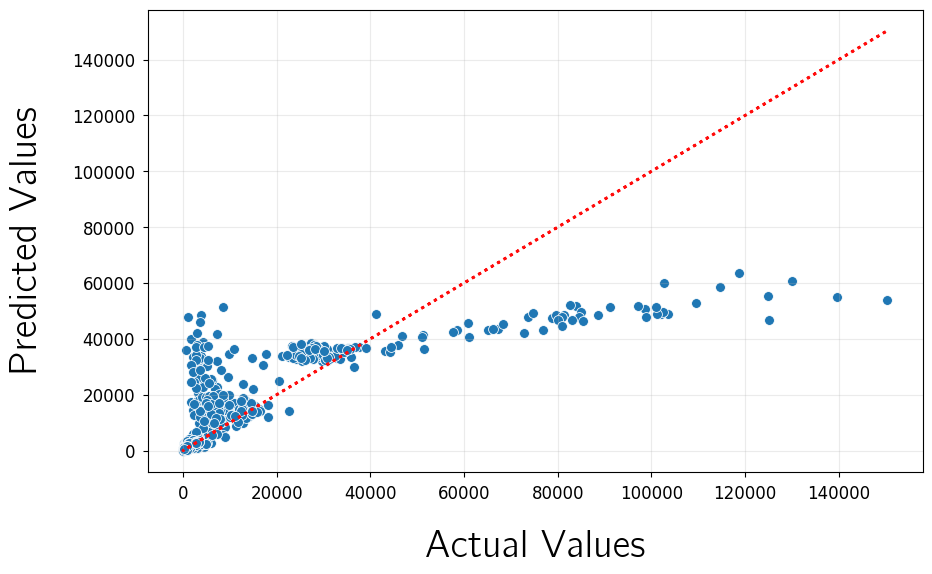

In [ ]:
# Graph predicted vs. actual results for neural network model
font_prop = fm.FontProperties(fname='cmunbmr.ttf')

with plt.style.context('seaborn-v0_8-paper'):
  plt.figure(figsize=(10, 6))
  sns.scatterplot(x=nn_comparison['mean_grad_variance'], y=nn_comparison['Predicted'], s=50)
  plt.plot(test_Y, test_Y, color='#FF0C0C', linestyle='dotted', linewidth=2)

  plt.xlabel('Actual Values', fontsize=27, fontproperties=font_prop, labelpad=20)
  plt.ylabel('Predicted Values', fontsize=27, fontproperties=font_prop, labelpad=20)
  plt.grid(True, alpha=.25)
  plt.tick_params(axis='both', labelsize=12)
  plt.show()